In [1]:
import sys
import os
sys.path.append("../../../../src/")
#Imports
import numpy as np
import scipy as sp
import numpy.linalg as la
import matplotlib.pyplot as plt
#Custom made imports
import single_particle_sector as sps
from time import time

In [2]:
#Ground State Fidelity
def overlap(U,V):
    L = U.shape[0]//2
    U = U[:,:L]
    V = V[:,:L]
    overlap_matrix = U.conj().T @ V
    return la.det(overlap_matrix)

def plot_pn_differences(ns, taus, Ut_tau, GS_T_tau, times_tau, L, N_steps, D):
    for j in range(len(taus)):
        plt.figure()
        G_t = [sps.G_tfim(Ut_tau[j][ti][:, :L]) for ti in range(0, N_steps, N_steps // D)]
        G_gs = [sps.G_tfim(GS_T_tau[j][ti][:, :L]) for ti in range(0, N_steps, N_steps // D)]
        for n in ns:
            P_t = np.array([sps.P_n(n, Gi, L) for Gi in G_t])
            P_gs = np.array([sps.P_n(n, Gi, L) for Gi in G_gs])
            plt.plot(times_tau[j][::N_steps // D], P_t - P_gs, label=f"{n}")
        plt.title(f"L = {L}, tau = {taus[j]}")
        plt.legend()
        plt.hlines(0,times_tau[j][0],times_tau[j][-1],colors="black",linestyles="--")

        plt.xlim(times_tau[j][0], times_tau[j][-1])
        plt.show()
def plot_and_return_projectors(ns, taus, Ut_tau, GS_T_tau, times_tau, L, N_steps,  num_timepoints=100):
    """
    Plot and return time-dependent probabilities P_n for a list of subsystem sizes `ns`.

    Parameters:
        ns (list): List of subsystem sizes n to compute P_n.
        taus (list): List of tau values for different quench speeds.
        Ut_tau (list): Evolved states, structured as Ut_tau[j][t], for j in taus and t in time steps.
        GS_T_tau (list): Ground states at each time, structured like Ut_tau.
        times_tau (list): Time arrays corresponding to each tau.
        L (int): Total system size.
        N_steps (int): Total number of time steps.
        sps (module): Module containing functions G_tfim and P_n.
        num_timepoints (int): Number of time points to sample from N_steps (default: 100).

    Returns:
        results (dict): Dictionary of the form:
            results[j][n] = (P_t_array, P_gs_array)
            where j indexes the tau list and n is the subsystem size.

    Example:
        For tau index j=0 and subsystem size n=3,
            results[0][3][0] is the array of P_n(t) from the evolved state.
            results[0][3][1] is the array of P_n(t) from the instantaneous ground state.
    """
    results = {}

    for j in range(len(taus)):
        plt.figure()
        time_indices = list(range(0, N_steps, N_steps // num_timepoints))
        G_t = [sps.G_tfim(Ut_tau[j][ti][:, :L]) for ti in time_indices]
        G_gs = [sps.G_tfim(GS_T_tau[j][ti][:, :L]) for ti in time_indices]
        t_sampled = times_tau[j][::N_steps // num_timepoints]

        results[j] = {}

        for n in ns:
            # Compute probabilities P_n(t) for both evolved and instantaneous ground states
            P_t = np.array([sps.P_n(n, Gi, L) for Gi in G_t])
            P_gs = np.array([sps.P_n(n, Gi, L) for Gi in G_gs])
            results[j][n] = (P_t, P_gs)

            # Plot both as line and scatter
            plt.plot(t_sampled, P_t, label=f"{n}")
            plt.scatter(t_sampled, P_gs, s=5)

        plt.title(f"L = {L}, tau = {taus[j]}")
        plt.legend()
        plt.xlim(times_tau[j][0], times_tau[j][-1])
        plt.show()

    return results

def compute_final_pn_differences(ns, taus, Ut_tau, GS_T_tau, L):
    """
    Compute the difference in P_n between the final evolved state and final ground state
    for each tau and subsystem size n.

    Parameters:
        ns (list): List of subsystem sizes n to compute P_n.
        taus (list): List of tau values.
        Ut_tau (list): Evolved states, structured as Ut_tau[j][-1], j indexing taus.
        GS_T_tau (list): Ground states at each time, structured like Ut_tau.
        L (int): Total system size.
        sps (module): Module with G_tfim and P_n functions.

    Returns:
        diffs_tau (np.ndarray): Array of shape (len(taus), len(ns)), where
            diffs_tau[j, i] = P_n(ns[i]) at final time for tau[j] (evolved - ground).
    
    Example:
        diffs_tau[2, 5] gives the difference in P_n for ns[5] at final time for taus[2].
    """
    diffs_tau = []

    for j in range(len(taus)):
        # Only final time step
        G_t_final  = sps.G_tfim(Ut_tau[j][-1][:, :L])
        G_gs_final = sps.G_tfim(GS_T_tau[j][-1][:, :L])

        diffs_n = []
        for n in ns:
            if n> 8:
                print(n)
            Pt  = sps.P_n(n, G_t_final, L)
            Pgs = sps.P_n(n, G_gs_final, L)
            diffs_n.append(Pt - Pgs)

        diffs_tau.append(diffs_n)

    return np.array(diffs_tau)  # shape: (len(taus), len(ns))


In [7]:
#Model Parameters
L = 150
J = -1
h0 = 0
hf = 2
taus = [100]
N_steps = 1000

#Time Evolved States:
Ut_tau = []
GS_T_tau = []
times_tau =[]
for tau in taus:
    times = np.linspace(0,tau,N_steps)

    Ut = sps.TFIM_time_evolve(N_steps,tau,h0,hf,J,L)
    #Ground States
    GS_T = []
    for ti in range(N_steps):
        h = sps.h_t(times[ti],tau,h0,hf)
        H = sps.H_bdg(h,L,J)
        E,V = la.eigh(H)
        GS_T.append(V)
    Ut_tau.append(Ut)
    GS_T_tau.append(GS_T)
    times_tau.append(times)

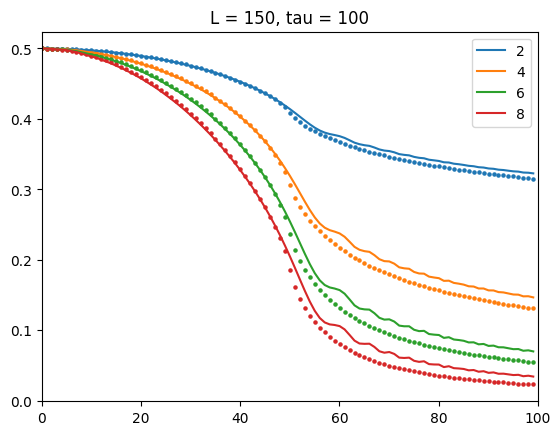

In [8]:
ns = [2,4,6,8]

projector_dat = plot_and_return_projectors(ns, taus, Ut_tau, GS_T_tau, times_tau, L, N_steps,  num_timepoints=100)

In [13]:
# ns = [2,3,4,5,6,7,8]
# D = 100
# #i = time step
# plot_pn_differences(ns, taus, Ut_tau, GS_T_tau, times_tau, L, N_steps, D)

In [5]:
ns = [i for i in range(1,14+1)]
diffs_tau = compute_final_pn_differences(ns, taus, Ut_tau, GS_T_tau, L)


9
10
11
12
13
14
9
10
11
12
13
14
9
10
11
12
13
14
9
10
11
12
13
14


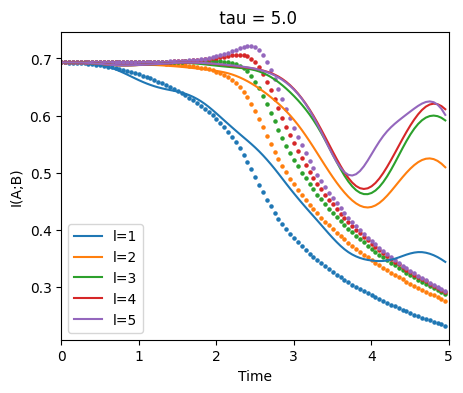

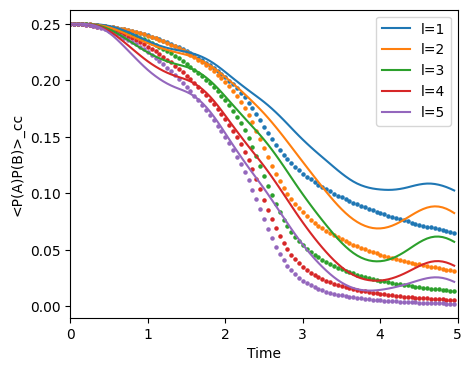

In [7]:
j = 1
x = times_tau[j][::10]

plt.figure(figsize=(5,4))
for n in projector_dat[j].keys():
    if n <= 5:
        y_theory = np.log(projector_dat[j][2*n][0] / projector_dat[j][n][0]**2)
        y_data = np.log(projector_dat[j][2*n][1] / projector_dat[j][n][1]**2)
        plt.plot(x, y_theory, label=f"l={n}")
        plt.scatter(x, y_data, s=5)
plt.title(f" tau = {times_tau[j][-1]}")
plt.xlabel("Time")
plt.ylabel("I(A;B)")
plt.xlim(times_tau[j][0], times_tau[j][-1])
plt.legend()
plt.show()

plt.figure(figsize=(5,4))
for n in projector_dat[j].keys():
    if n <= 5:
        y_theory = projector_dat[j][2*n][0] - projector_dat[j][n][0]**2
        y_data = projector_dat[j][2*n][1] - projector_dat[j][n][1]**2
        plt.plot(x,  y_theory, label=f"l={n}")
        plt.scatter(x, y_data, s=5)

#plt.title(f"Difference: Data - Theory \n tau = {times_tau[j][-1]}")
#plt.hlines(0,times_tau[j][0],times_tau[j][-1], colors="black", linestyles="--")
plt.xlabel("Time")
plt.ylabel("<P(A)P(B)>_cc")
plt.xlim(times_tau[j][0], times_tau[j][-1])
plt.legend()
plt.show()



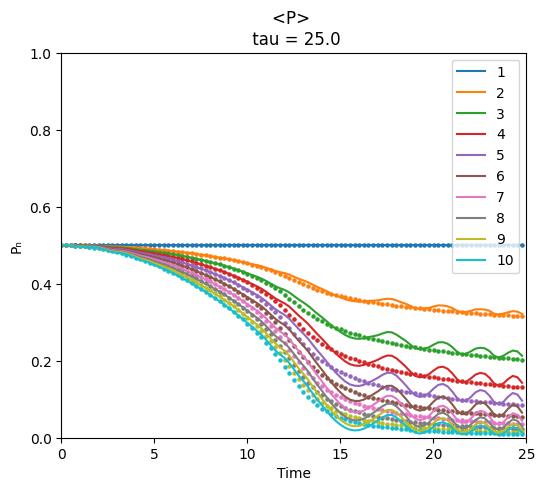

(-0.05, 0.05)

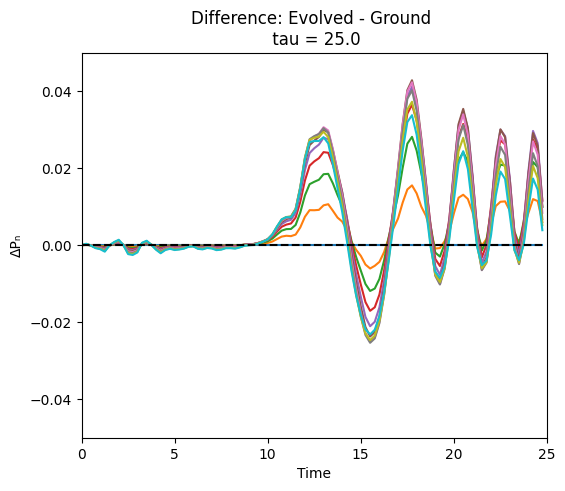

In [12]:
j = 2 # 4 10 20
x = times_tau[j][::10]

plt.figure(figsize=(6,5))
for n in projector_dat[j].keys():
    plt.plot(x, projector_dat[j][n][0], label=f"{n}")
    plt.scatter(x, projector_dat[j][n][1], s=5)

plt.title(f"<P> \n tau = {times_tau[j][-1]}")
plt.xlabel("Time")
plt.ylabel("Pₙ")
plt.ylim(0, 1)
plt.xlim(times_tau[j][0], times_tau[j][-1])
plt.legend()
plt.show()


plt.figure(figsize=(6,5))
for n in projector_dat[j].keys():
    diff = np.array(projector_dat[j][n][0]) - np.array(projector_dat[j][n][1])
    plt.plot(x, diff, label=f"{n}")
#plt.legend()
plt.title(f"Difference: Evolved - Ground \n tau = {times_tau[j][-1]}")
plt.xlabel("Time")
plt.ylabel("ΔPₙ")
plt.hlines(0,x[0],x[-1],colors="black",linestyles="--")
plt.xlim(times_tau[j][0], times_tau[j][-1])

plt.ylim(-.05, .05)



In [ ]:

dat_Reshape = np.array(diffs_tau)

plt.figure()25
for j in range(0,len(taus),1):
    plt.plot(ns[1:],(dat_Reshape[j,1:]), label=f"{taus[j]}")
#plt.yscale("log")
#plt.legend()
plt.hlines(0,2,16,color="black",linestyles="--")
plt.xlim(2,14)
plt.xlabel("n")
plt.ylabel("Delta")


NameError: name 'diffs_tau' is not defined

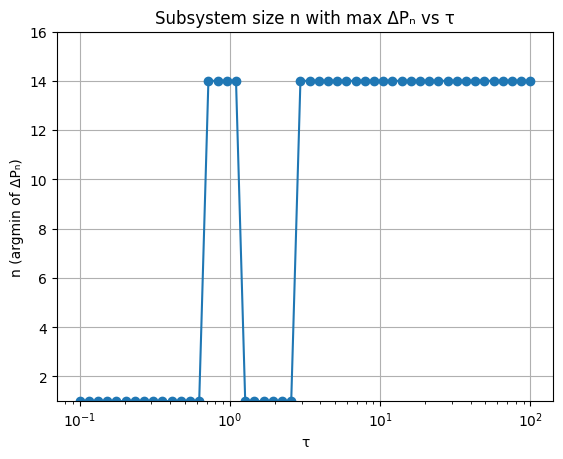

In [23]:
dat_Reshape = np.array(diffs_tau)

# Find index of maximum for each j
max_indices = np.argmin(dat_Reshape[:, :], axis=1)  # skip ns[0]
max_ns = [ns[:][i] for i in max_indices]

# Plot
plt.figure()
plt.plot(taus, max_ns, marker="o")
plt.xlabel("τ")
plt.ylabel("n (argmin of ΔPₙ)")
plt.title("Subsystem size n with max ΔPₙ vs τ")
plt.grid(True)
plt.xscale("log")
plt.ylim(1,16)
plt.show()



In [82]:
Data_array = np.empty((len(taus),len(ns)))
for j in range(0,len(taus)):
    for ni in range(0,len(ns)):
        Data_array[j,ni] = (dat_Reshape[j,ni]-dat_Reshape[j,2])#[ni]

       # (diffs_tau[j][:,-1]- diffs_tau[j][0,-1])[ni]




Text(0.5, 1.0, 'Deviation from ground state expectation value ')

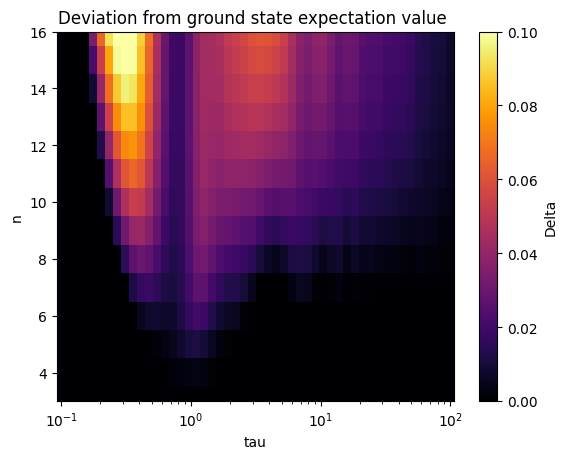

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Assume shape: Data_array.shape = (len(taus), len(ns))
Z = np.array(Data_array)  # shape (15, 8)
X, Y = np.meshgrid(ns, taus) # shape (15, 8)
#X, Y = np.meshgrid(ns,taus)
plt.pcolormesh(Y, X, -Z, shading='auto',cmap="inferno",vmin=0,vmax=.1) 
plt.ylim(3,16) # set z-lim here
plt.colorbar(label='Delta')
plt.xlabel('tau')
plt.ylabel('n')
plt.xscale("log")
plt.title('Deviation from ground state expectation value ')
#plt.show()
#plt.savefig("FullSubspace_n=16_adiabatic_deviation.png")


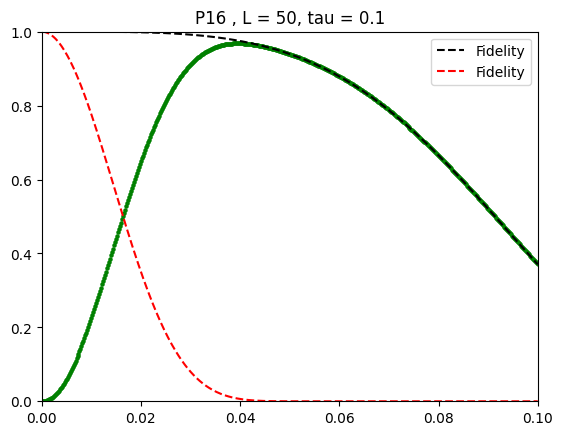

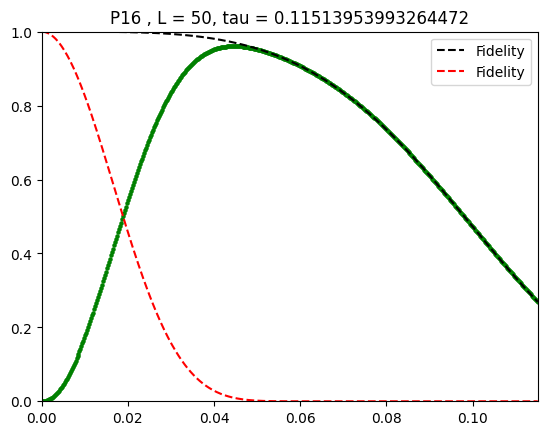

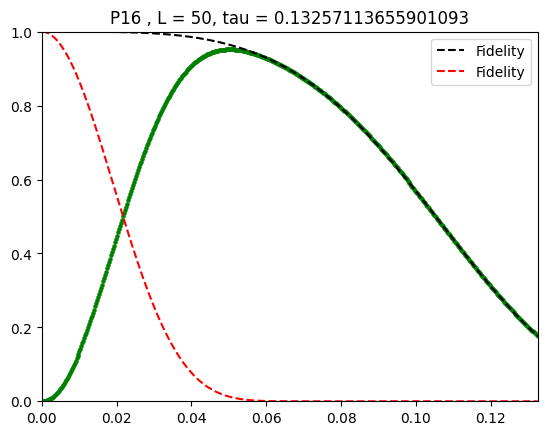

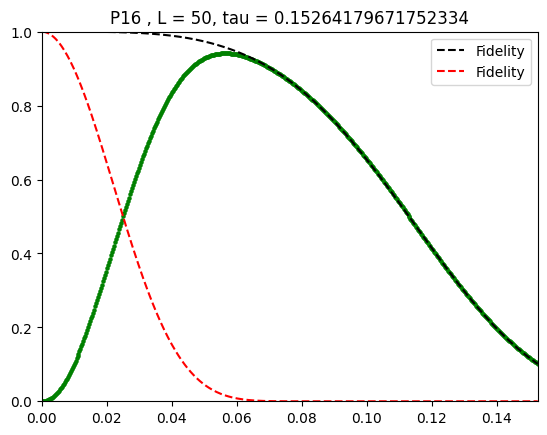

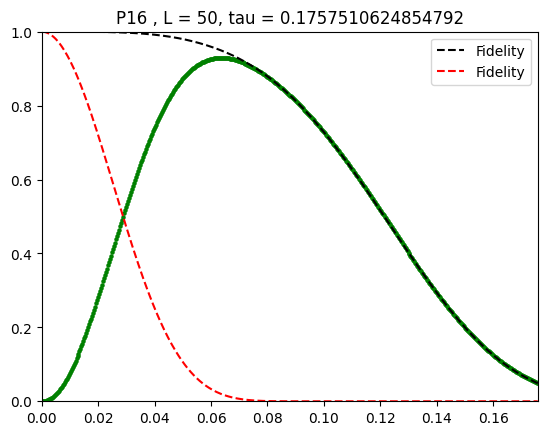

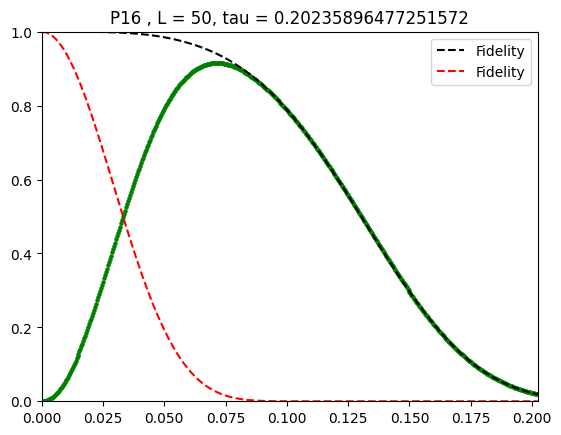

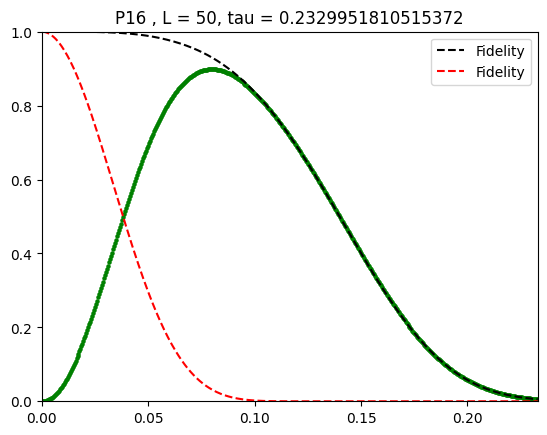

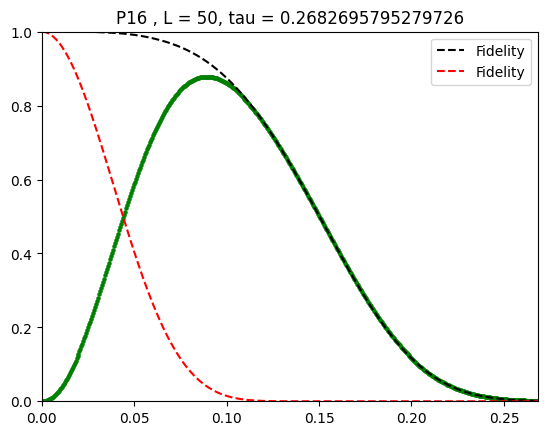

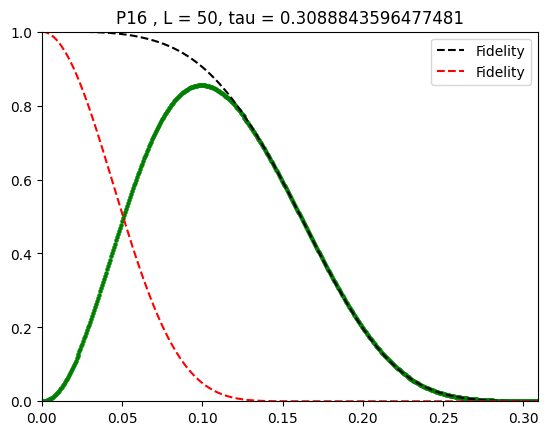

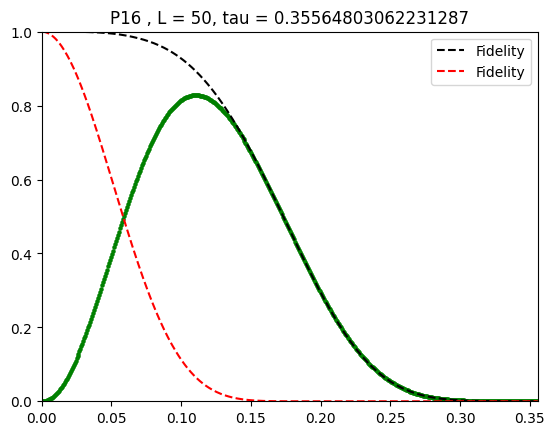

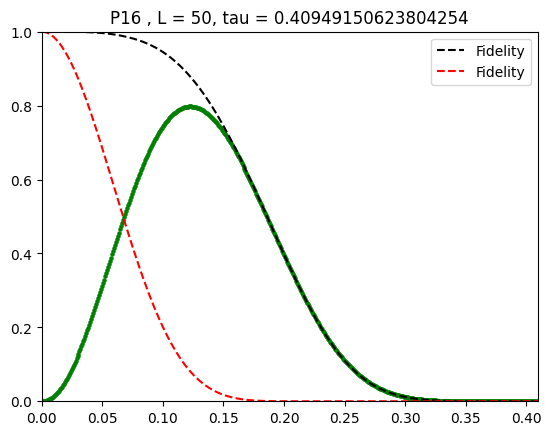

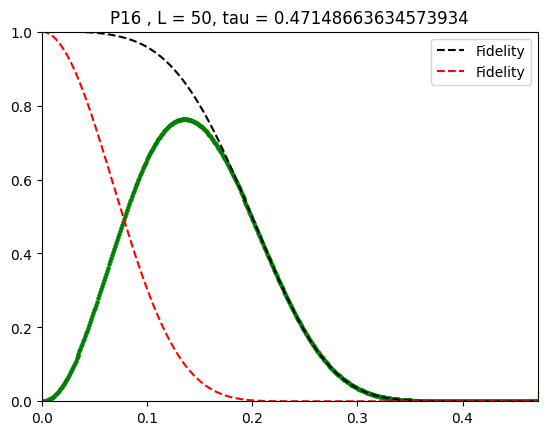

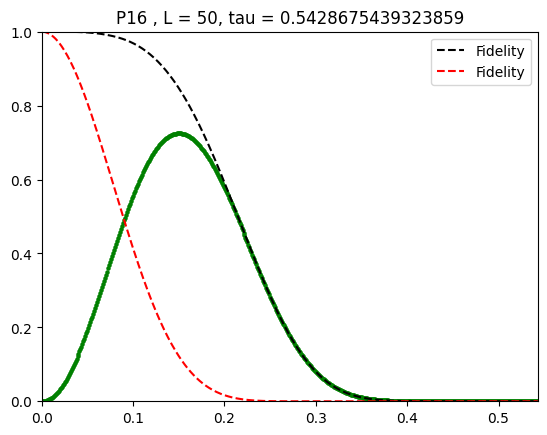

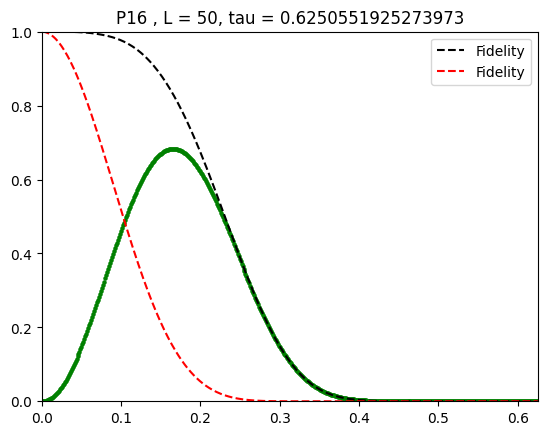

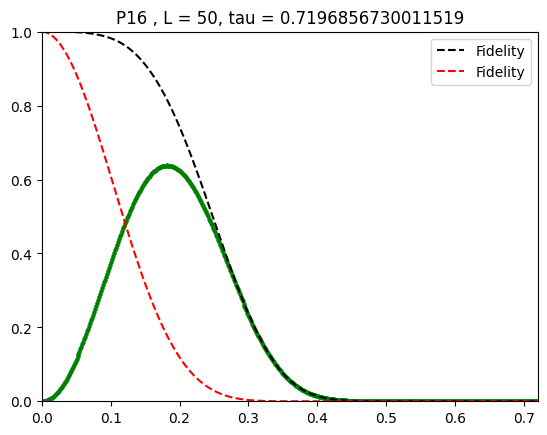

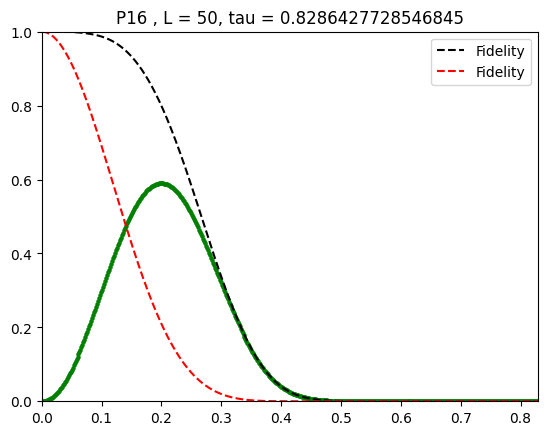

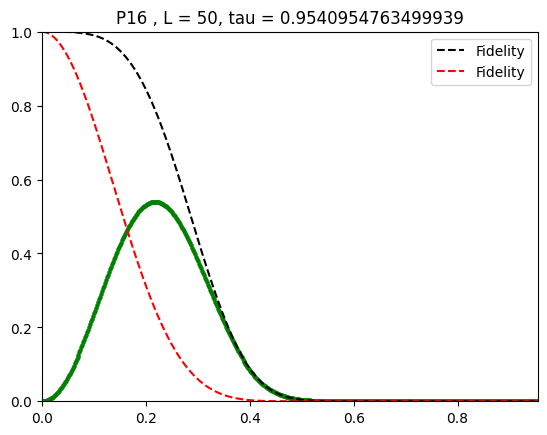

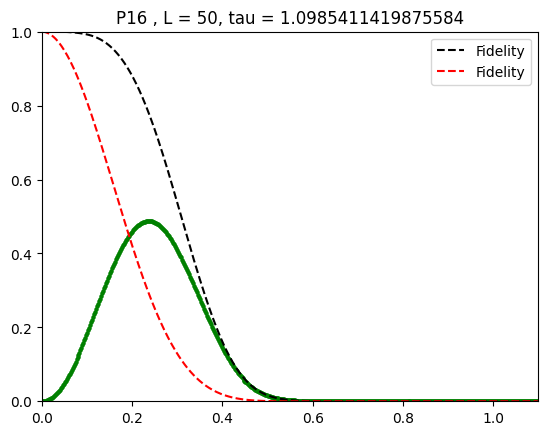

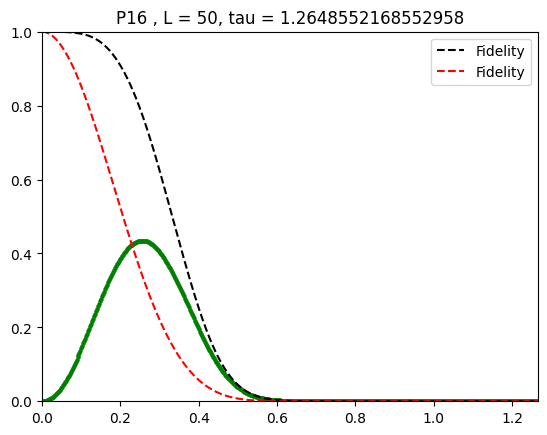

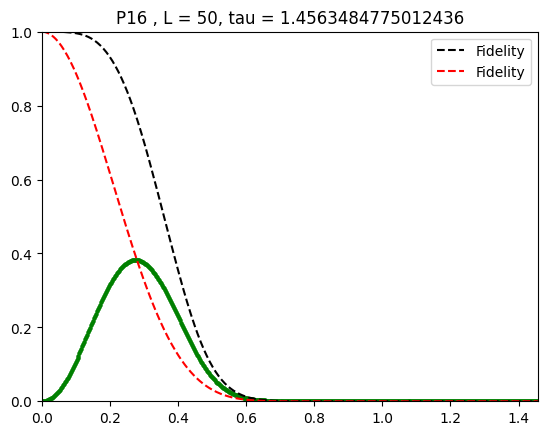

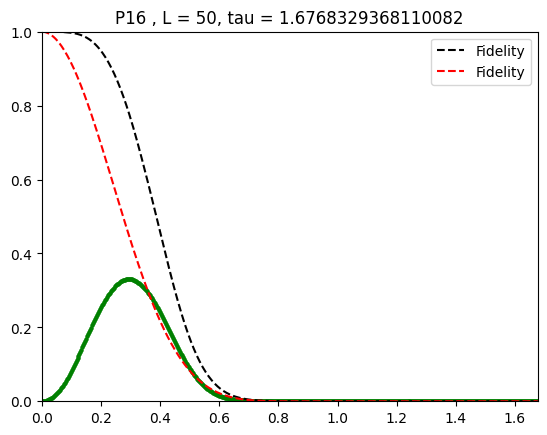

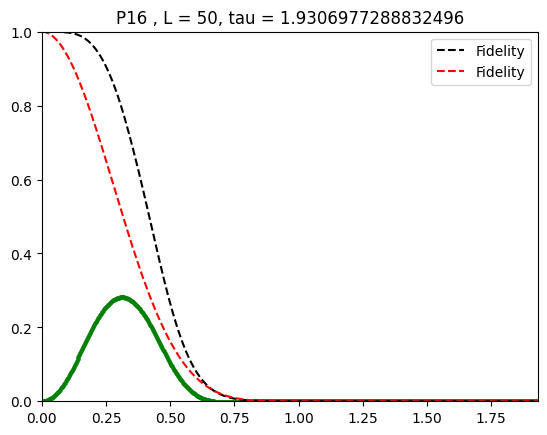

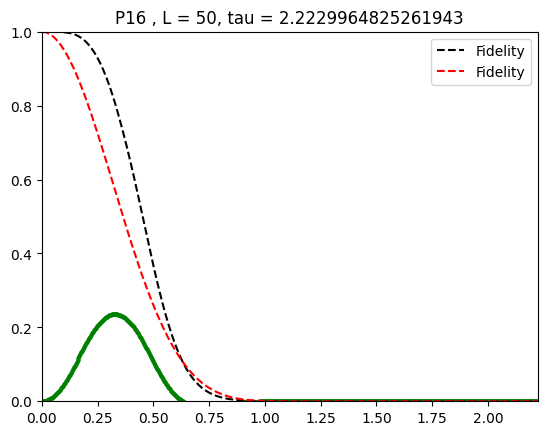

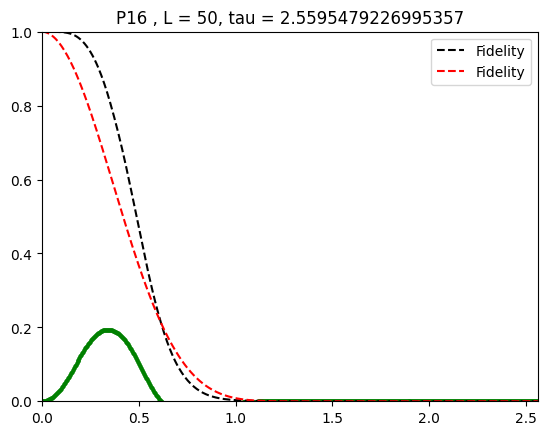

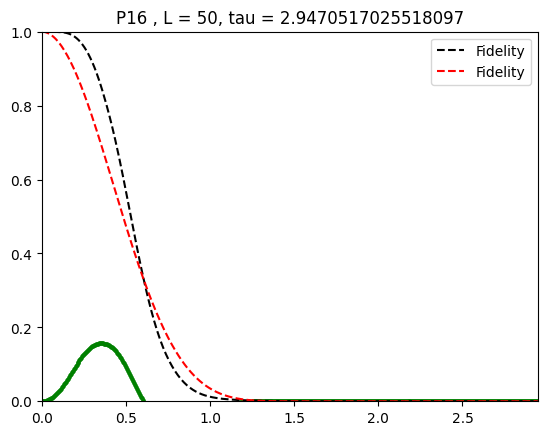

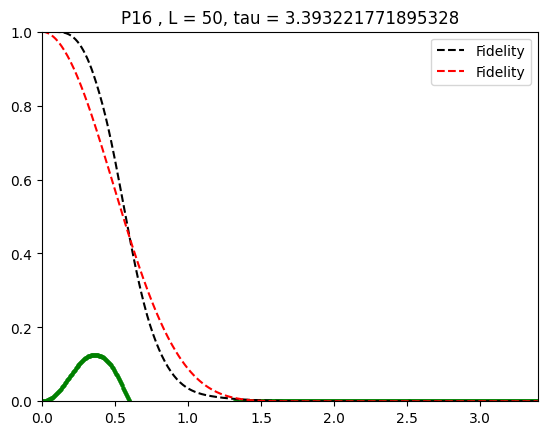

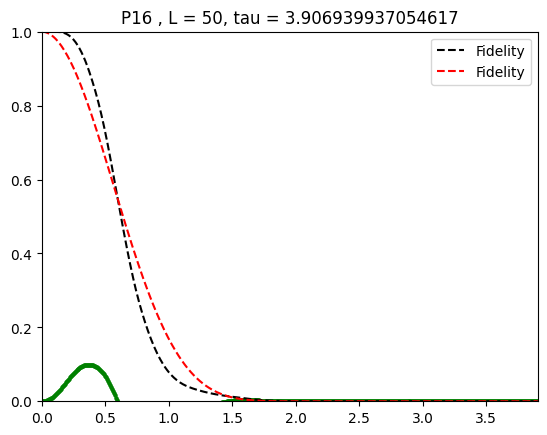

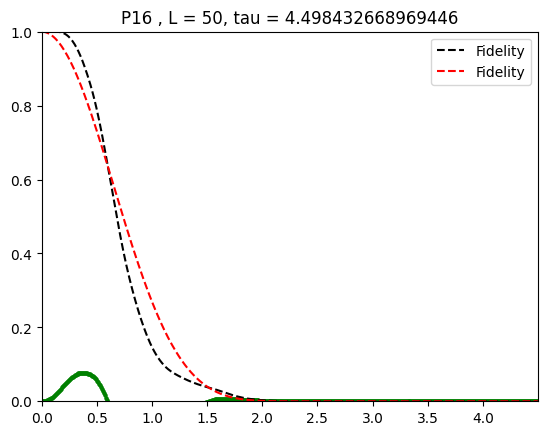

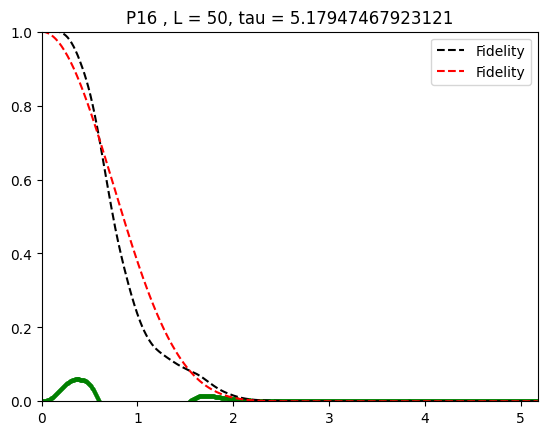

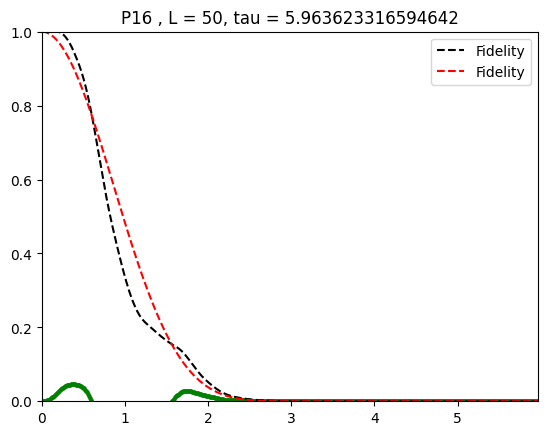

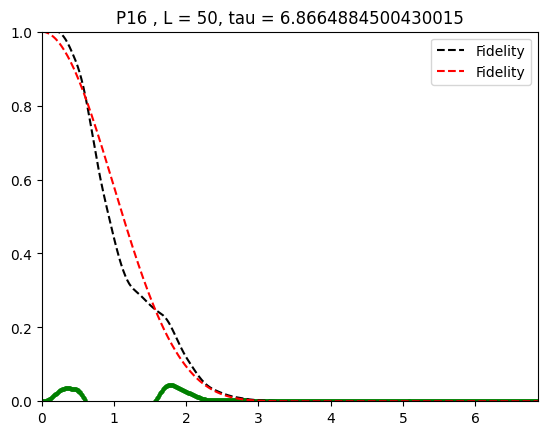

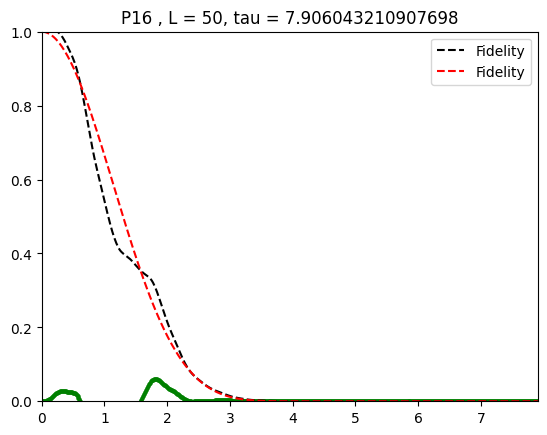

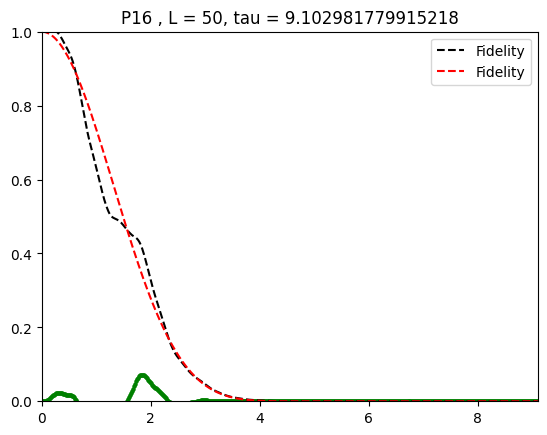

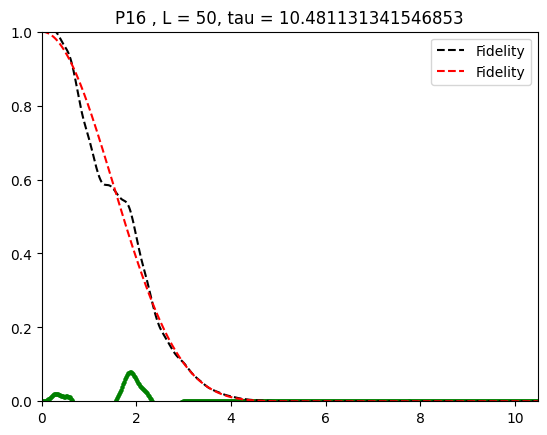

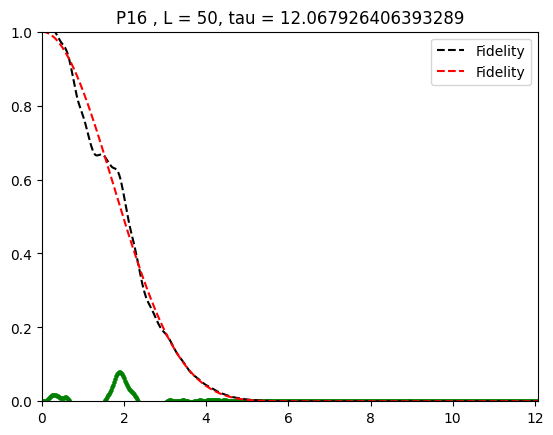

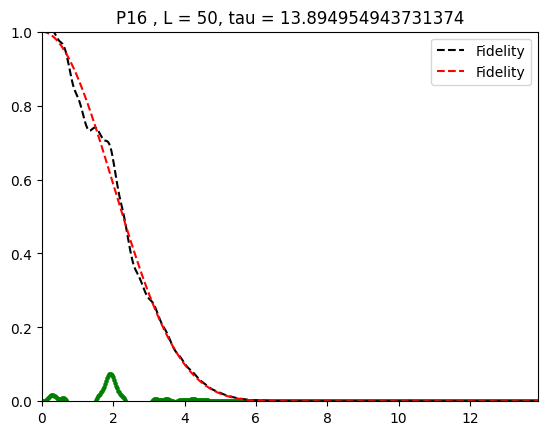

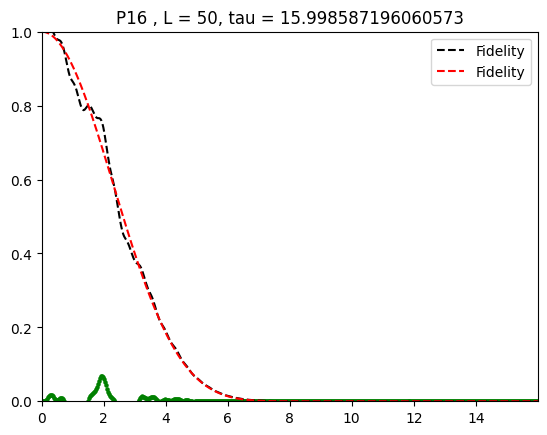

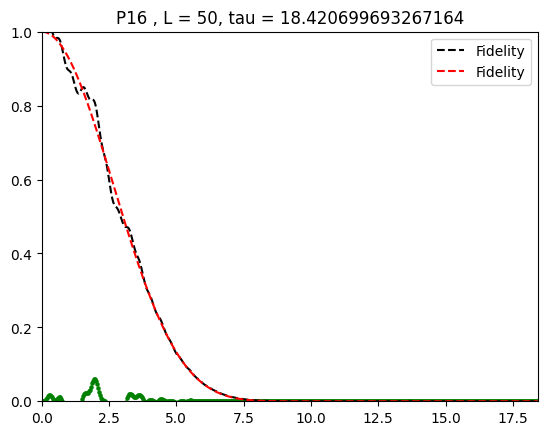

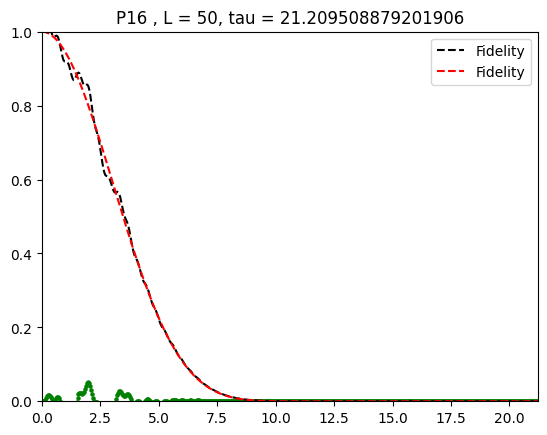

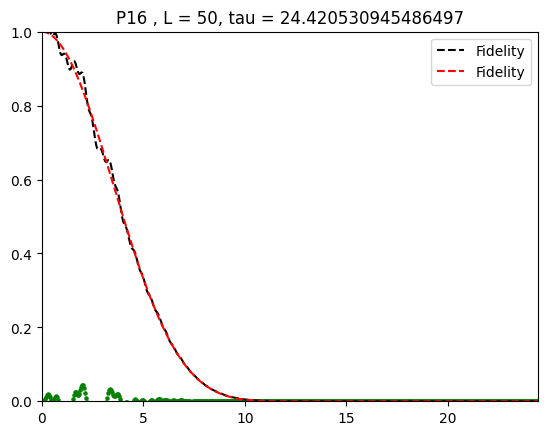

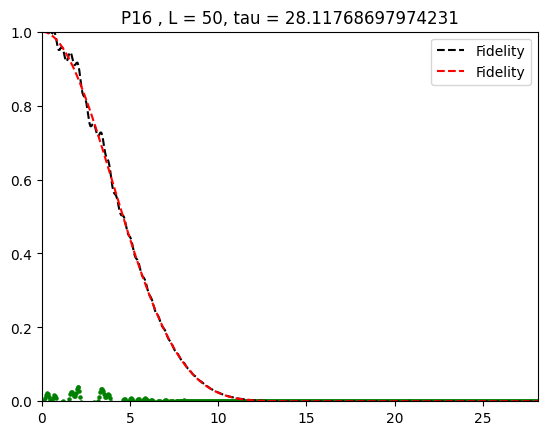

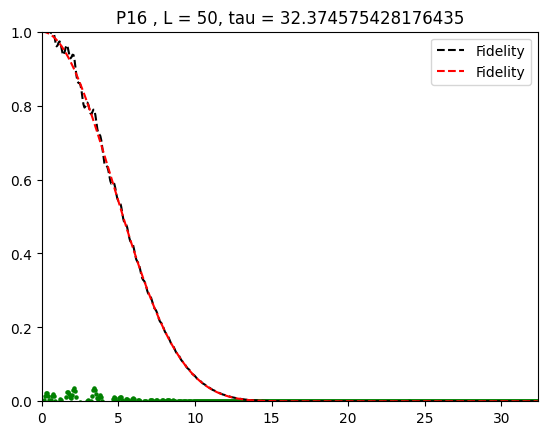

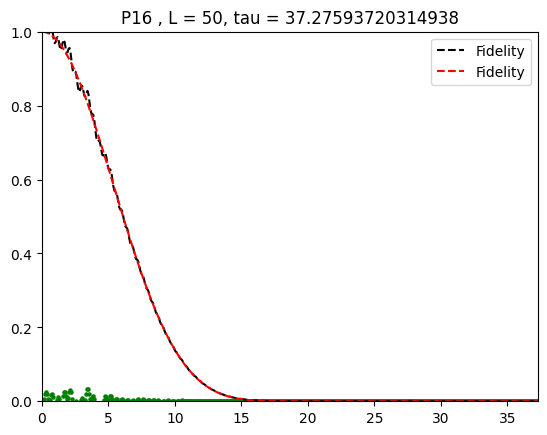

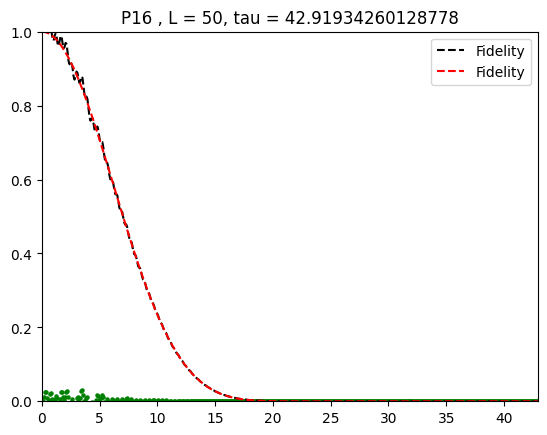

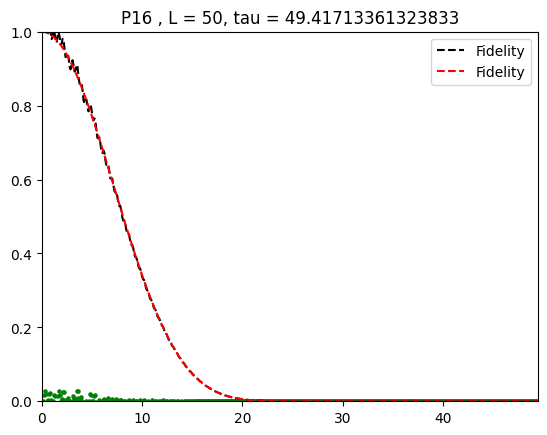

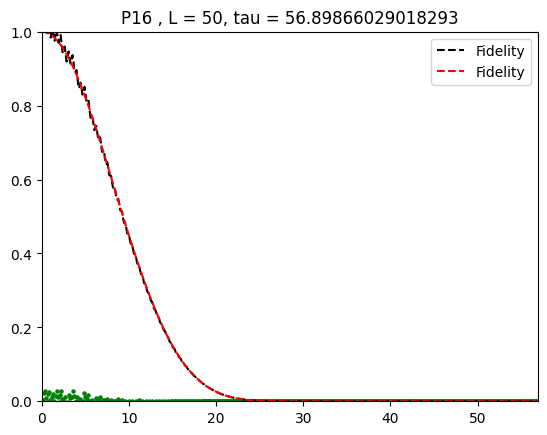

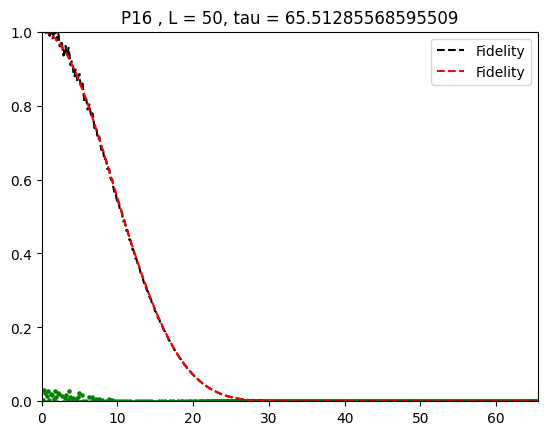

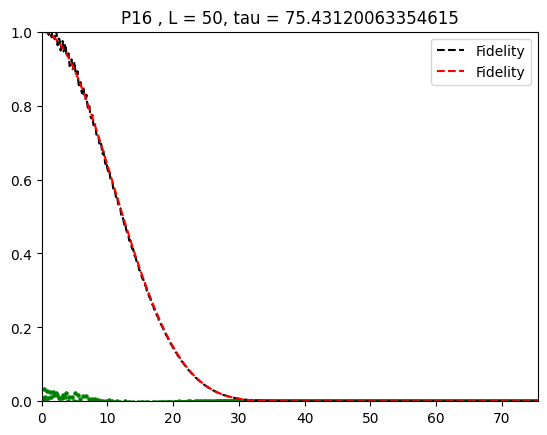

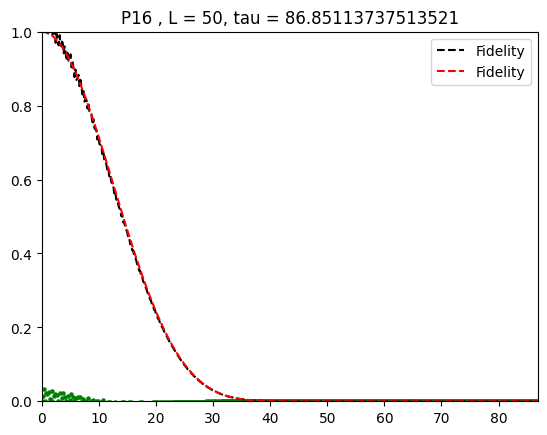

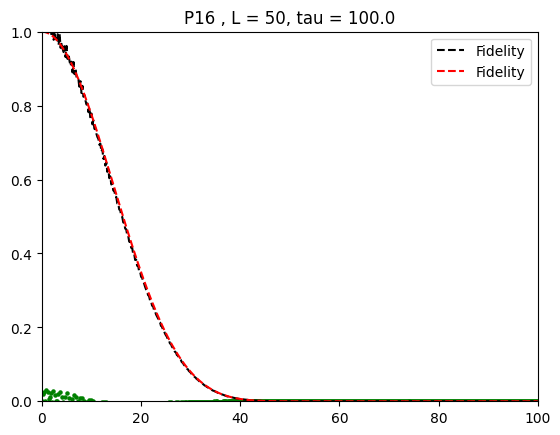

In [145]:

for j in range(0,len(taus)):
    plt.figure()    
    G_t =[sps.G_tfim(Ut_tau[j][ti][:,:L]) for ti in range(N_steps) ]
    G_gs = [sps.G_tfim(GS_T_tau[j][ti][:, :L]) for ti in range(N_steps)]
    fidelity = np.array([np.abs(overlap(Ut_tau[j][ti],GS_T_tau[j][0]))**2 for ti in range(N_steps)])
    fid2 =  np.array([np.abs(overlap(GS_T_tau[j][ti],GS_T_tau[j][0]))**2 for ti in range(N_steps)])
   # diffs_tau.append(np.array(diffs_n))
    diff = fidelity-fid2
    plt.plot(times_tau[j],fidelity, label =f"Fidelity", color = "black",linestyle="--" )
    plt.plot(times_tau[j],fid2, label =f"Fidelity", color = "red",linestyle="--" )
    plt.scatter(times_tau[j],diff,s=5,color="green")
    plt.title(f"P{n} , L = {L}, tau = {taus[j]}")
    plt.legend()
    plt.xlim(times_tau[j][0],times_tau[j][-1])
    plt.ylim(0,1)
    plt.show()

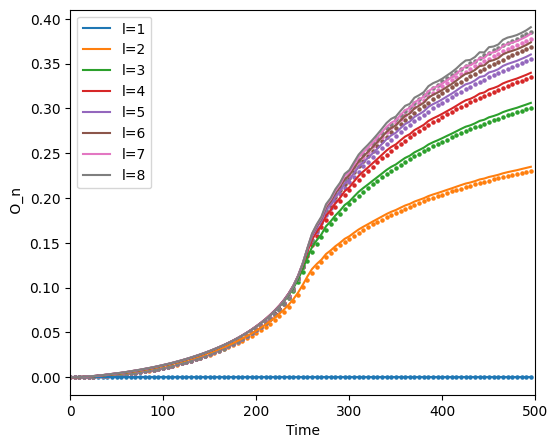

In [27]:
j = 3


plt.figure(figsize=(6,5))
for n in ns:
    plt.plot(times_tau[j][::10], -np.log(projector_dat[j][n][0]) / (n) - min(-np.log(projector_dat[j][n][0]) / (n) ), label=f"l={n}")
    plt.scatter(times_tau[j][::10], -np.log(projector_dat[j][n][1]) / (n)- min(-np.log(projector_dat[j][n][0]) / (n)), s=5)
    #plt.plot(times_tau[j][::10], -np.log(projector_dat[j][n][0]) / (n) - min(-np.log(projector_dat[j][n][0])) / (n)-(
     #    -np.log(projector_dat[j][n][1]) / (n)- min(-np.log(projector_dat[j][n][0]) / (n))), label = f"n = {n}")
plt.xlabel("Time")
plt.ylabel(" O_n")
plt.xlim(times_tau[j][0], times_tau[j][-1])
plt.legend()
plt.show()
